In [1]:
import cv2 as cv
from dataclasses import dataclass
from pathlib import Path
import requests
from tqdm.notebook import tqdm

@dataclass
class ImageInfo:
    image_path: Path
    url: str
    img: cv.Mat|None = None

    def download(self) -> cv.Mat:
        headers = {'User-Agent': 'ComputerVisionExperiments/0.0 (https://github.com/seafoodfry/ml-workspace/tree/main/gpu-sandbox/vision)'}
        response = requests.get(self.url, headers=headers)
        response.raise_for_status()

        img_data = response.content
        with open(self.image_path, 'wb') as f:
            f.write(img_data)
    
        # Opencv reads images in BGR.
        self.img = cv.imread(self.image_path, cv.IMREAD_UNCHANGED)

    def rgb(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2RGB)

    def gray(self) -> cv.Mat:
        return cv.cvtColor(self.img, cv.COLOR_BGR2GRAY)


class ImageCache:
    def __init__(self, base_path: str = './img/015-images'):
        self._base_path = Path(base_path)
        self._base_path.mkdir(parents=True, exist_ok=True)
        
        self._cache: dict[str, ImageInfo] = {
            'sixes': ImageInfo( # https://www.google.com/search?q=building+number+666&client=firefox-b-1-d&sca_esv=179f217c49a14e41&udm=2&biw=1148&bih=635&ei=CErzZ7eUDIKeptQP082liQ4&ved=0ahUKEwi3uI7jgMWMAxUCj4kEHdNmKeEQ4dUDCBQ&uact=5&oq=building+number+666&gs_lp=EgNpbWciE2J1aWxkaW5nIG51bWJlciA2NjZI1wxQ9AJYpgpwAXgAkAEAmAF8oAGxAqoBAzMuMbgBA8gBAPgBAZgCBKAC0AHCAgoQABiABBhDGIoFwgIGEAAYBxgewgIFEAAYgATCAgQQABgewgIGEAAYBRgewgIGEAAYCBgemAMAiAYBkgcBNKAHwQuyBwEzuAfFAQ&sclient=img#vhid=ECotylJcNGZa2M&vssid=mosaic
                image_path=self._base_path / 'six.jpg',
                url='https://www.nj.com/resizer/v2/https%3A%2F%2Fadvancelocal-adapter-image-uploads.s3.amazonaws.com%2Fimage.nj.com%2Fhome%2Fnjo-media%2Fwidth2048%2Fimg%2Fledgerupdates_impact%2Fphoto%2F2018%2F08%2F09%2F24760354-standard.jpg?auth=aa40cd25b82be069490d71785d08fce0973eca08ef00f915344da175d2c2db90&width=1280&quality=90',
            )
        }
        for img_key, img in tqdm(self._cache.items(), desc="Downloading images"):
            img.download()

    def images(self):
        """Return all the image names registered."""
        return self._cache.keys()

    def __getitem__(self, img_name: str) -> ImageInfo:
        """Allow dictionary-like access to loaded images."""
        if img_name not in self._cache:
            self.load_img(img_name)
        return self._cache[img_name]

    def cwd(self):
        return self._base_path


CACHE = ImageCache()

In [3]:
CACHE.images()

dict_keys(['sixes'])

In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

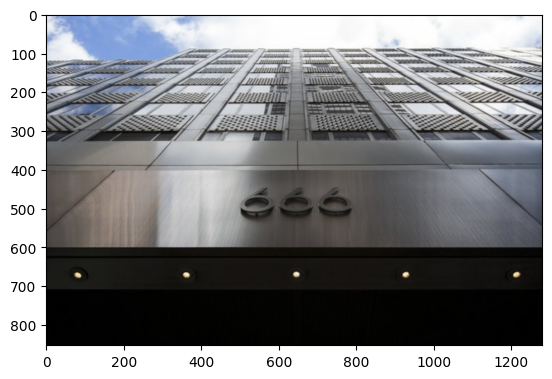

In [27]:
img = CACHE['sixes'].img
img_rgb = CACHE['sixes'].rgb()
img_gray = CACHE['sixes'].gray()

plt.imshow(img_rgb)
plt.show()

In [77]:
"""
def MSER_create(
    _delta=5,           # Intensity variation threshold
    _min_area=60,       # Minimum area of detected region
    _max_area=14400,    # Maximum area of detected region
    _max_variation=0.25,# Maximum variation between nested regions
    _min_diversity=0.2, # Minimum diversity between regions
    _max_evolution=200, # Maximum number of evolution steps
    _area_threshold=1.01,# Area threshold for pruning
    _min_margin=0.003,  # Minimum margin for pruning
    _edge_blur_size=5   # Edge blur size
):
    Creates an MSER (Maximally Stable Extremal Regions) detector with the specified parameters.
    
    MSER is a feature detection algorithm that finds connected components in an image 
    where the brightness remains stable across various threshold levels.
    
    Parameters:
    -----------
    _delta : int
        Step size between intensity thresholds. Controls how aggressively regions are merged.
        Smaller values detect more regions but are more sensitive to noise.
        Typical values: 1-10 (5 is a good default)
    
    _min_area : int
        Minimum area (in pixels) of regions to be detected.
        Used to filter out very small regions that are likely noise.
        Typical values: 30-100 depending on expected size of features
    
    _max_area : int
        Maximum area (in pixels) of regions to be detected.
        Used to filter out extremely large regions like backgrounds.
        Typical values: 5000-50000 depending on image size
    
    _max_variation : float
        Maximum variation between nested extremal regions to be considered stable.
        Lower values produce more stable regions but fewer detections.
        Range: 0-1, typical values: 0.1-0.5
    
    _min_diversity : float
        Minimum diversity between parent and child regions.
        Controls the region merging threshold based on similarity.
        Range: 0-1, typical values: 0.1-0.4
    
    _max_evolution : int
        Maximum evolution steps in the watershed algorithm.
        Limits computational complexity for very complex regions.
        Typical values: 100-300
    
    _area_threshold : float
        Rate of growth threshold for stability test.
        Areas growing faster than this rate are considered unstable.
        Typical values: 1.01-1.05
    
    _min_margin : float
        Minimum margin for region stability.
        Higher values produce more stable regions.
        Range: 0.001-0.05
    
    _edge_blur_size : int
        Size of blurring kernel for edge detection preprocessing.
        Helps reduce noise sensitivity at image edges.
        Typical values: 0-7 (0 means no blurring)
    
    Returns:
    --------
    cv2.MSER : MSER detector object
    
    Notes:
    ------
    - Input image for detectRegions() does NOT have to be grayscale, but grayscale
      is strongly recommended as MSER works based on intensity values. Color images 
      will be converted to grayscale internally, losing control over the conversion.
    
    - detectRegions() returns (regions, bboxes) where:
      - regions: list of point arrays, each containing the pixel coordinates of a region
      - bboxes: list of (x, y, width, height) tuples defining bounding rectangles
    
    - MSER works well for text detection but requires careful parameter tuning
      and post-processing to achieve good results.
    return cv2.MSER_create(
        _delta, _min_area, _max_area, _max_variation, _min_diversity,
        _max_evolution, _area_threshold, _min_margin, _edge_blur_size
    )
"""
# Initialize MSER detector.
mser = cv.MSER_create()
mser = cv2.MSER_create(
    delta=5,           # Determines stability of region (5-10 usually good)
    min_area=60,       # Minimum area of detected region (adjust based on digit size)
    max_area=2_000,    # Maximum area (adjust based on your image)
    max_variation=0.25 # Maximum variation for stability
)

In [72]:
regions, bboxes = mser.detectRegions(img_gray)

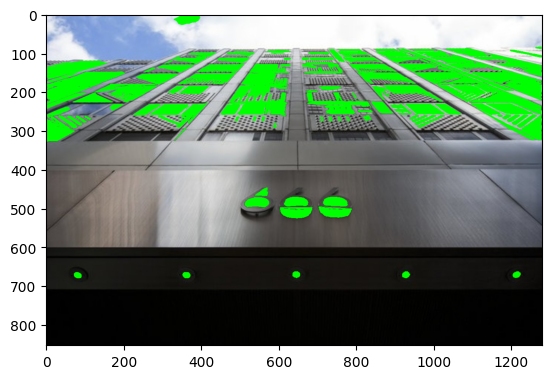

In [73]:
image_rgb = img_rgb.copy()

cv.drawContours(image_rgb, regions, -1, color=(0, 255, 0), thickness=1)

plt.imshow(image_rgb)
plt.show()

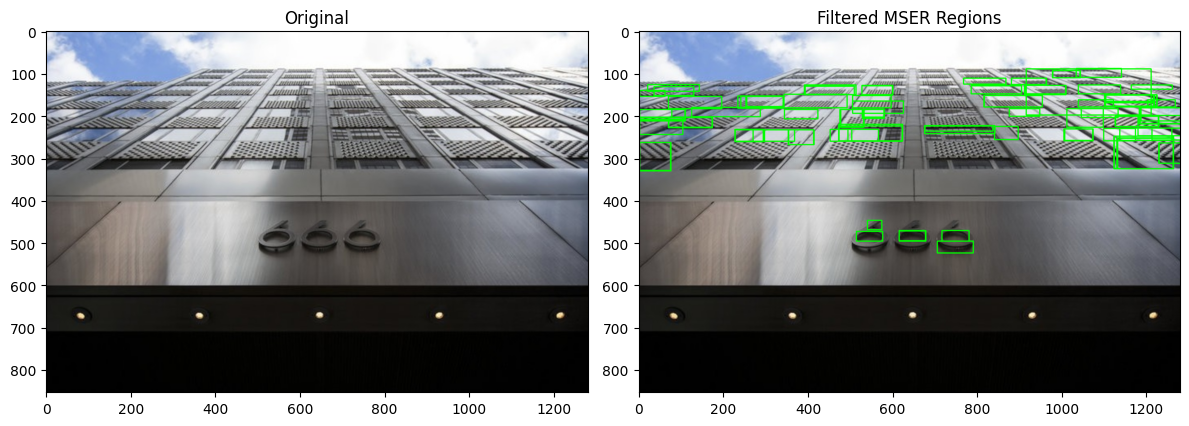

In [78]:
# Create a copy of original image for visualization
vis = img.copy()

# Filter regions based on properties that are likely to be digits
filtered_regions = []
filtered_bboxes = []
for i, region in enumerate(regions):
    # Get the bounding box
    x, y, w, h = bboxes[i]
    
    # Filter based on aspect ratio (typical for digits)
    #aspect_ratio = float(w) / h
    #if 0.1 < aspect_ratio < 5.5
        
    # Filter based on region size
    region_area = cv2.contourArea(region)
    if 1_000 < region_area < 5_000:
        # Calculate region fill ratio (compactness)
        hull = cv2.convexHull(region)
        hull_area = cv2.contourArea(hull)
        if region_area > 0 and hull_area > 0:
            fill_ratio = region_area / hull_area
            
            # Digits typically have high fill ratio
            if fill_ratio > 0.9:  # Adjust as needed
                filtered_regions.append(region)
                filtered_bboxes.append(bboxes[i])
                # Draw bounding rectangle on visualization
                cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 2)


# Display results
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(121)
plt.imshow(img_rgb)
plt.title('Original')

# Filtered MSER regions
plt.subplot(122)
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('Filtered MSER Regions')

plt.tight_layout()
plt.show()